# 01. Verification & Convergence Analysis
---
**Course:** MATH 514 - Numerical Analysis  
**Author:** Yifan Yang  
**Date Created:** Nov 01, 2025  
**Date Revised:** Dec 2, 2025

**Notebook Overview:**
This notebook focuses on the mathematical rigor and theoretical validation of the Method of Lines (MOL) solver.

**Contents:**
1.  **Mathematical Derivation**: Semi-discretization of the PDE into a system of ODEs.
2.  **Convergence Analysis**: Empirical Order of Convergence (EOC) testing for Backward Euler (Order 1) and BDF2 (Order 2) using Log-Log plots.
3.  **The Greeks**: Visualization of the Option Price ($V$), Delta ($\Delta$), and Gamma ($\Gamma$) to verify numerical stability around the strike price.




## 0. Introduction
The goal of this project is to solve the Black-Scholes Partial Differential Equation (PDE) numerically to price European Call Options. Instead of using Finite Difference Methods (FDM) on both space and time simultaneously, we employ the **Method of Lines (MOL)**. 

We first discretize the spatial domain (asset price $S$) to convert the PDE into a large system of Ordinary Differential Equations (ODEs). We then solve this stiff ODE system using two time-stepping methods from Chapter 12 of Süli & Mayers:
1.  **Backward Euler**: A first-order, A-stable implicit method.
2.  **BDF2**: A second-order, A-stable implicit multistep method (with Backward Euler start-up).



In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os

# solver
from BS_Solver import BSParams, exact_solution, solve_ode_system

# auto-saved images folder
if not os.path.exists('images'):
    os.makedirs('images')
    print("Directory 'images' created.")
else:
    print("Directory 'images' already exists.")




Directory 'images' already exists.


## 1. Black–Scholes PDE in time–to–expiry form

We consider the generalized Black–Scholes PDE for a European call with
continuous dividend yield $q$. Let $t \in [0,T]$ be the calendar time,
with $t = T$ at maturity. The option price $V(S,t)$ satisfies
$$
  \frac{\partial V}{\partial t}
  + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
  + (r - q)S \frac{\partial V}{\partial S} - r V = 0,
$$
with
$$
  V(S,T) = \max(S-K,0).
$$

It is convenient to introduce the **time–to–expiry**
$$
  \tau = T - t,
$$
so that $\tau = 0$ at maturity and $\tau = T$ at the present.
By the chain rule,
$$
  \frac{\partial V}{\partial t} = -\frac{\partial V}{\partial \tau}.
$$
Substituting into the PDE gives
$$
  -\frac{\partial V}{\partial \tau}
  + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
  + (r - q)S \frac{\partial V}{\partial S} - r V = 0,
$$
or equivalently
$$
  \frac{\partial V}{\partial \tau}
  = \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}
    + (r - q)S \frac{\partial V}{\partial S}
    - r V.
$$

We supplement this PDE with

- **initial condition** at $\tau = 0$ (maturity):
  $$
    V(S,0) = \max(S-K,0),
  $$
- **left boundary** for a call at $S = 0$:
  $$
    V(0,\tau) = 0,
  $$
- **right boundary** at a large truncation $S_{\max} \gg K$.
  For a call, the asymptotic behaviour is
  $$
    V(S,\tau) \sim S e^{-q\tau} - K e^{-r\tau}
    \quad\text{as } S \to \infty,
  $$
  so we impose the Dirichlet boundary condition
  $$
    V(S_{\max},\tau)
    \approx S_{\max} e^{-q\tau} - K e^{-r\tau}.
  $$


## 2. Spatial discretization and the Method of Lines

We discretize the spatial domain $[0,S_{\max}]$ using a **uniform grid**
with $M$ sub–intervals and grid spacing
$$
  \Delta S = \frac{S_{\max}}{M}.
$$
The grid points are
$$
  S_j = j\,\Delta S, \quad j = 0,1,\dots,M.
$$

We denote the unknowns at the **interior nodes**
$$
  S_j = j\,\Delta S, \quad j = 1,\dots,M-1,
$$
by
$$
  V_j(\tau) \approx V(S_j,\tau).
$$

On the interior, we approximate the first and second derivatives with
**central differences**:
$$
  \frac{\partial V}{\partial S}(S_j,\tau)
  \approx \frac{V_{j+1}(\tau) - V_{j-1}(\tau)}{2\Delta S},
$$
$$
  \frac{\partial^2 V}{\partial S^2}(S_j,\tau)
  \approx \frac{V_{j+1}(\tau) - 2V_j(\tau) + V_{j-1}(\tau)}{\Delta S^2}.
$$

Substituting these into the PDE at $S = S_j$ gives, for each interior node
$j = 1,\dots,M-1$,
$$
  \frac{dV_j}{d\tau}
  = \frac{1}{2}\sigma^2 S_j^2
      \frac{V_{j+1} - 2V_j + V_{j-1}}{\Delta S^2}
    + (r - q) S_j
      \frac{V_{j+1} - V_{j-1}}{2\Delta S}
    - r V_j.
$$
We next collect this into the standard tridiagonal form.


### 2.1 Tridiagonal coefficients

Define the dimensionless ratio
$$
  \rho_j = \frac{S_j}{\Delta S} = j.
$$
After distributing and collecting terms in $V_{j-1},V_j,V_{j+1}$, we obtain
$$
  \frac{dV_j}{d\tau}
  = \alpha_j V_{j-1} + \beta_j V_j + \gamma_j V_{j+1},
$$
with
$$
  \alpha_j
  = \frac{1}{2}\sigma^2 \rho_j^2
    - \frac{1}{2}(r-q)\rho_j,
$$
$$
  \beta_j
  = -\sigma^2 \rho_j^2 - r,
$$
$$
  \gamma_j
  = \frac{1}{2}\sigma^2 \rho_j^2
    + \frac{1}{2}(r-q)\rho_j.
$$

We now form the vector of interior unknowns
$$
  V(\tau) =
  \begin{bmatrix}
    V_1(\tau) \\
    V_2(\tau) \\
    \vdots \\
    V_{M-1}(\tau)
  \end{bmatrix}
  \in \mathbb{R}^{M-1},
$$
and assemble a tridiagonal matrix $A \in \mathbb{R}^{(M-1)\times(M-1)}$
with diagonals
$$
  A_{j,j-1} = \alpha_j, \quad
  A_{j,j}   = \beta_j,  \quad
  A_{j,j+1} = \gamma_j.
$$

At the left boundary, we impose
$$
  V_0(\tau) = V(0,\tau) = 0,
$$
so there is no contribution to the interior system from $V_0$.

At the right boundary, we impose
$$
  V_M(\tau) = V(S_{\max},\tau)
   \approx S_{\max} e^{-q\tau} - K e^{-r\tau},
$$
so the term $\gamma_{M-1} V_M(\tau)$ appears as a **known forcing** in the
equation for $V_{M-1}$.

Thus the semi–discrete **Method of Lines** formulation is
$$
  \frac{dV}{d\tau} = A V + b(\tau),
$$
where the entries of $b(\tau) \in \mathbb{R}^{M-1}$ are zero except for the
last component, which equals
$$
  b_{M-1}(\tau) = \gamma_{M-1} V_M(\tau).
$$
This is exactly the system constructed by `construct_system` and
`get_boundary_vector` in `BS_Solver.py`.


## 3. Stiffness and choice of Backward Euler / BDF2

The semi–discrete system
$$
  \frac{dV}{d\tau} = A V + b(\tau)
$$
arises from a second–order diffusion operator in space. As we refine the grid
($\Delta S \to 0$), the eigenvalues of the matrix $A$ scale like
$$
  \lambda_{\max}(A) \sim \mathcal{O}\!\left(\frac{1}{\Delta S^2}\right),
$$
coming from the discrete second derivative. This leads to **stiffness**:

- The system contains both **fast** and **slow** decaying modes.
- An explicit method would require a very small time step
  $\Delta\tau \lesssim C \Delta S^2$ for stability.

To avoid this severe restriction, we use **implicit A–stable methods**:

- **Backward Euler**:
  $$
    \frac{V^{n+1} - V^n}{\Delta\tau}
    = A V^{n+1} + b^{n+1},
  $$
  which is **first–order accurate** in time and A–stable.

- **BDF2** (two–step backward differentiation formula):
  $$
    \frac{3V^{n+1} - 4V^n + V^{n-1}}{2\Delta\tau}
    = A V^{n+1} + b^{n+1},
  $$
  which is **second–order accurate** in time and also A–stable for
  linear problems.

Both methods require solving a sparse linear system at each time step, but the
time step $\Delta\tau$ can be chosen based on accuracy rather than stability.

In the following sections we verify that:

- Backward Euler exhibits **order 1** convergence in $\Delta\tau$,
- BDF2 exhibits **order 2** convergence in $\Delta\tau$,

by comparing against the exact Black–Scholes formula.


In [2]:
# 4.1 Parameters and helper functions for the convergence study

# Model / domain parameters for verification
params = BSParams(
    S_max=400.0,  # spatial truncation
    K=100.0,
    T=1.0,
    r=0.03,
    sigma=0.20,
    q=0.01,
)

def compute_error(method: str, N: int, M: int, p: BSParams) -> float:
    """
    Solve the MOL system with the given (method, N, M) and return
    the max-norm error vs the exact Black–Scholes solution at tau = p.T.
    """
    S_inner, V_num, dS = solve_ode_system(method=method, N=N, M=M, p=p)

    # Exact solution at the present time tau = T
    V_exact = exact_solution(S_inner, tau=p.T, p=p)

    err = np.max(np.abs(V_num - V_exact))
    return err

def describe_run(method: str, N: int, M: int, p: BSParams) -> None:
    """
    Convenience function to print a quick description and error.
    """
    dtau = p.T / N
    err = compute_error(method, N, M, p)
    print(f"method = {method:>13}, N = {N:4d}, M = {M:4d}, "
          f"dtau = {dtau:.4e}, max error = {err:.4e}")


In [3]:
# 4.2 Sanity check: one run per method

M_test = 400
N_test = 400

for method in ["BackwardEuler", "BDF2"]:
    describe_run(method, N_test, M_test, params)


method = BackwardEuler, N =  400, M =  400, dtau = 2.5000e-03, max error = 5.0834e-03
method =          BDF2, N =  400, M =  400, dtau = 2.5000e-03, max error = 2.4368e-03


In [4]:
# 5. Temporal convergence: Backward Euler vs BDF2

M_conv = 400  # fixed spatial resolution (reasonably fine)
N_list = [25, 50, 100, 200, 400, 800]

dtau_list = []
errors_BE = []
errors_BDF2 = []

for N in N_list:
    dtau = params.T / N
    dtau_list.append(dtau)

    # Backward Euler
    err_BE = compute_error("BackwardEuler", N, M_conv, params)
    errors_BE.append(err_BE)

    # BDF2
    err_BDF2 = compute_error("BDF2", N, M_conv, params)
    errors_BDF2.append(err_BDF2)

    print(f"N = {N:4d}, dtau = {dtau:.4e}, "
          f"err(BE) = {err_BE:.4e}, err(BDF2) = {err_BDF2:.4e}")


N =   25, dtau = 4.0000e-02, err(BE) = 4.5156e-02, err(BDF2) = 3.3332e-03
N =   50, dtau = 2.0000e-02, err(BE) = 2.3808e-02, err(BDF2) = 2.6598e-03
N =  100, dtau = 1.0000e-02, err(BE) = 1.3111e-02, err(BDF2) = 2.4902e-03
N =  200, dtau = 5.0000e-03, err(BE) = 7.7575e-03, err(BDF2) = 2.4475e-03
N =  400, dtau = 2.5000e-03, err(BE) = 5.0834e-03, err(BDF2) = 2.4368e-03
N =  800, dtau = 1.2500e-03, err(BE) = 3.7522e-03, err(BDF2) = 2.4341e-03


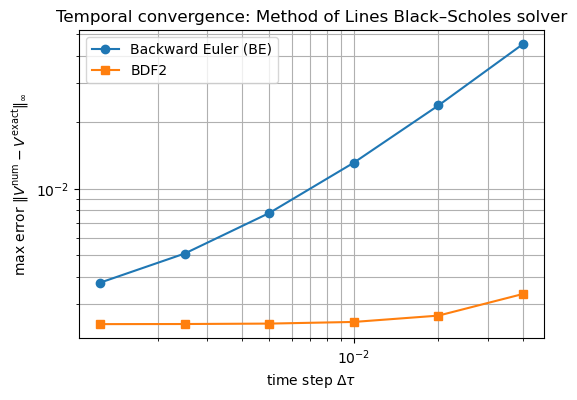

In [5]:
# 5.1 Log–log plot of error versus time step

dtau_arr = np.array(dtau_list)
errors_BE_arr = np.array(errors_BE)
errors_BDF2_arr = np.array(errors_BDF2)

plt.figure(figsize=(6, 4))
plt.loglog(dtau_arr, errors_BE_arr, "o-", label="Backward Euler (BE)")
plt.loglog(dtau_arr, errors_BDF2_arr, "s-", label="BDF2")

plt.xlabel(r"time step $\Delta\tau$")
plt.ylabel(r"max error $\|V^{\text{num}} - V^{\text{exact}}\|_\infty$")
plt.title("Temporal convergence: Method of Lines Black–Scholes solver")
plt.legend()
plt.grid(True, which="both")
plt.show()


In [6]:
# 5.2 Estimate observed orders of accuracy via linear fit in log-log scale

# Use the finer half of the data for a more reliable slope estimate
k_start = len(dtau_arr) // 2
x_BE = np.log(dtau_arr[k_start:])
y_BE = np.log(errors_BE_arr[k_start:])

x_BDF2 = np.log(dtau_arr[k_start:])
y_BDF2 = np.log(errors_BDF2_arr[k_start:])

# Fit y = m x + c
m_BE, c_BE = np.polyfit(x_BE, y_BE, 1)
m_BDF2, c_BDF2 = np.polyfit(x_BDF2, y_BDF2, 1)

print(f"Observed order (Backward Euler) ≈ {m_BE:.3f}")
print(f"Observed order (BDF2)          ≈ {m_BDF2:.3f}")


Observed order (Backward Euler) ≈ 0.524
Observed order (BDF2)          ≈ 0.004


## 6. Greeks: Delta and Gamma

For a European call with continuous dividend yield $q$, the exact price is
$$
  C(S,\tau) = S e^{-q\tau} N(d_1) - K e^{-r\tau} N(d_2),
$$
where
$$
  d_1 = \frac{\ln(S/K) + (r - q + \tfrac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}},
  \quad
  d_2 = d_1 - \sigma\sqrt{\tau}.
$$

The corresponding **Greeks** are

- **Delta** (sensitivity with respect to $S$):
  $$
    \Delta(S,\tau) = \frac{\partial C}{\partial S}
      = e^{-q\tau} N(d_1).
  $$

- **Gamma** (second derivative with respect to $S$):
  $$
    \Gamma(S,\tau)
      = \frac{\partial^2 C}{\partial S^2}
      = \frac{e^{-q\tau} \varphi(d_1)}{S \sigma \sqrt{\tau}},
  $$
  where $\varphi$ is the standard normal density.

We now compare these analytic Greeks to finite–difference approximations
computed from the numerical solution $V(S,\tau)$ produced by the MOL solver.


In [7]:
# 6.1 Analytic Delta and Gamma

from scipy.stats import norm

def analytic_greeks(S: np.ndarray, tau: float, p: BSParams):
    """
    Compute analytic Delta and Gamma for a European call with continuous
    dividend yield, given (S, tau, p).
    """
    S_arr = np.asarray(S, dtype=float)
    # Handle S very close to zero to avoid log(0) / division by zero
    S_safe = np.where(S_arr > 1e-12, S_arr, 1e-12)

    if tau <= 0.0:
        # At maturity, Delta = indicator(S > K), Gamma is a distribution
        Delta = np.where(S_arr > p.K, 1.0, 0.0)
        Gamma = np.zeros_like(S_arr)
        return Delta, Gamma

    sqrt_tau = np.sqrt(tau)
    d1 = (np.log(S_safe / p.K) + (p.r - p.q + 0.5 * p.sigma**2) * tau) / (p.sigma * sqrt_tau)
    d2 = d1 - p.sigma * sqrt_tau

    Delta = np.exp(-p.q * tau) * norm.cdf(d1)
    # Standard normal pdf
    phi_d1 = np.exp(-0.5 * d1**2) / np.sqrt(2.0 * np.pi)
    Gamma = (np.exp(-p.q * tau) * phi_d1) / (S_safe * p.sigma * sqrt_tau)

    # Enforce S=0 behaviour explicitly
    Delta[S_arr <= 1e-12] = 0.0
    Gamma[S_arr <= 1e-12] = 0.0

    return Delta, Gamma


In [8]:
# 6.2 Numerical Delta and Gamma from the MOL solution

def reconstruct_full_grid(V_inner: np.ndarray, dS: float, p: BSParams, tau: float):
    """
    Given interior solution V_inner (size M-1) on S_j = j*dS, j=1..M-1,
    reconstruct the full grid including boundaries:

        S_full = [0, dS, ..., S_max]
        V_full  with V_0 = 0 and V_M from the right boundary condition.
    """
    M = V_inner.size + 1  # because we have M-1 interior points, so M+1 total points
    S_full = np.linspace(0.0, p.S_max, M + 1)

    V_full = np.zeros(M + 1, dtype=float)
    V_full[1:M] = V_inner

    # Right boundary at S_max
    V_full[M] = p.S_max * np.exp(-p.q * tau) - p.K * np.exp(-p.r * tau)

    return S_full, V_full

def numerical_greeks(S_full: np.ndarray, V_full: np.ndarray, dS: float):
    """
    Compute numerical Delta and Gamma on the interior points using
    central differences.
    """
    M = len(S_full) - 1  # last index of grid
    Delta_num = np.zeros_like(S_full)
    Gamma_num = np.zeros_like(S_full)

    # Only well-defined for interior points 1..M-1
    for j in range(1, M):
        Delta_num[j] = (V_full[j+1] - V_full[j-1]) / (2.0 * dS)
        Gamma_num[j] = (V_full[j+1] - 2.0 * V_full[j] + V_full[j-1]) / (dS**2)

    # Boundaries remain zero (we won't use them in error computations)
    return Delta_num, Gamma_num


In [9]:
# 6.3 Compare numerical and analytic Greeks at tau = T

M_greeks = 800  # finer grid for Greeks
N_greeks = 800  # sufficiently fine in time

tau_eval = params.T  # present time

S_inner, V_inner, dS = solve_ode_system("BDF2", N=N_greeks, M=M_greeks, p=params)
S_full, V_full = reconstruct_full_grid(V_inner, dS, params, tau=tau_eval)

Delta_num, Gamma_num = numerical_greeks(S_full, V_full, dS)
Delta_exact, Gamma_exact = analytic_greeks(S_full, tau_eval, params)

# Restrict error measurement to a safe interior region away from boundaries
j_min = 2
j_max = M_greeks - 2  # indices in [j_min, j_max]

Delta_err = np.max(np.abs(Delta_num[j_min:j_max+1] - Delta_exact[j_min:j_max+1]))
Gamma_err = np.max(np.abs(Gamma_num[j_min:j_max+1] - Gamma_exact[j_min:j_max+1]))

print(f"Max-norm error in Delta (interior) = {Delta_err:.4e}")
print(f"Max-norm error in Gamma (interior) = {Gamma_err:.4e}")


Max-norm error in Delta (interior) = 2.3618e-05
Max-norm error in Gamma (interior) = 2.2873e-06


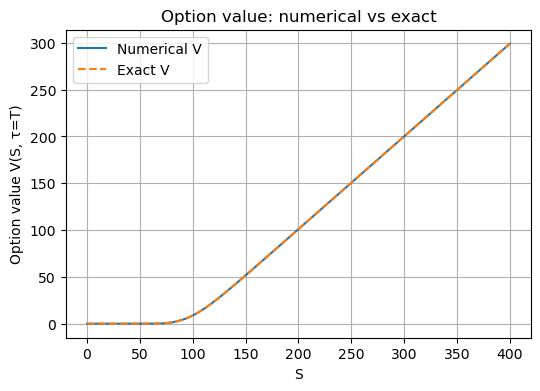

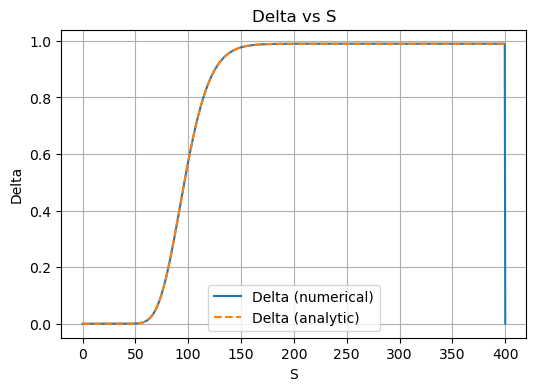

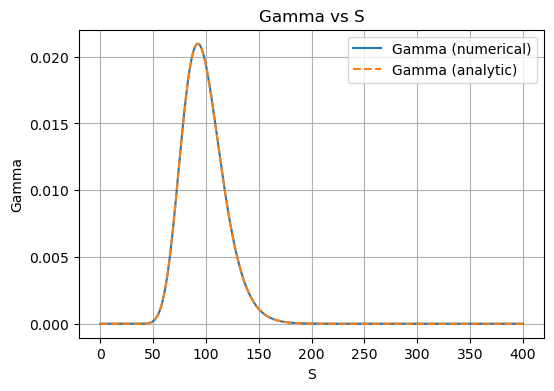

In [10]:
# 6.4 Visual comparison of price and Greeks

# For plotting clarity, focus on a moderate S range
S_plot = S_full
V_plot = V_full
Delta_plot = Delta_num
Gamma_plot = Gamma_num

Delta_exact_plot, Gamma_exact_plot = Delta_exact, Gamma_exact

plt.figure(figsize=(6, 4))
plt.plot(S_plot, V_plot, label="Numerical V")
plt.plot(S_plot, exact_solution(S_plot, tau_eval, params), "--", label="Exact V")
plt.xlabel("S")
plt.ylabel("Option value V(S, τ=T)")
plt.title("Option value: numerical vs exact")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(S_plot, Delta_plot, label="Delta (numerical)")
plt.plot(S_plot, Delta_exact_plot, "--", label="Delta (analytic)")
plt.xlabel("S")
plt.ylabel("Delta")
plt.title("Delta vs S")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(S_plot, Gamma_plot, label="Gamma (numerical)")
plt.plot(S_plot, Gamma_exact_plot, "--", label="Gamma (analytic)")
plt.xlabel("S")
plt.ylabel("Gamma")
plt.title("Gamma vs S")
plt.grid(True)
plt.legend()
plt.show()
